## chapter 07. 군집화2
### 7.4.GMM
- 가우시안 혼합모델 : 군집화를 적용하고자 하는 데이터가 여러 개의 가우시안 모델을 섞어 생성된 모델로 가정하여 수행하는 방식
- 따라서 GMM은 서로 다른 가우시안 분포곡선으로 데이터가 이루어 질 수 있다는 것을 가정하고 이를 구성하는 여러개의 정규분포 곡선을 추출하고, 개별 데이터가 그 정규곡선 중 어디에 속하는지를 본다. 
- 개별 정규분포의 평균과 분산, 각 데이터가 어떤 정규분포에 속하는지의 확률을 모수로 추정하고자 한다. (확률기반)

In [2]:
#GMM을 이용한 붓꽃 데이터 셋 군집화 
#데이터 생성 

from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length','sepal_width','petal_length','petal_width']
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target

In [5]:
#GMM모델의 적용
from sklearn.mixture import GaussianMixture
gmm=GaussianMixture(n_components=3, random_state=0).fit(iris.data)
gmm_cluster_labels=gmm.predict(iris.data)

#군집화의 결과 저장 
irisDF['gmm_cluster']=gmm_cluster_labels
irisDF['target']=iris.target

#target값이 잘 분류되었는지를 확인한다. (매핑결과 확인)
iris_result=irisDF.groupby(['target'])['gmm_cluster'].value_counts()
print(iris_result)

target  gmm_cluster
0       0              50
1       1              45
        2               5
2       2              50
Name: gmm_cluster, dtype: int64


In [6]:
#비교하기 위한 Kmeans의 적용
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300,random_state=0).fit(iris.data)
kmeans_cluster_labels = kmeans.predict(iris.data)
irisDF['kmeans_cluster'] = kmeans_cluster_labels
#매핑결과 확인
iris_result = irisDF.groupby(['target'])['kmeans_cluster'].value_counts()
print(iris_result)

target  kmeans_cluster
0       1                 50
1       2                 48
        0                  2
2       0                 36
        2                 14
Name: kmeans_cluster, dtype: int64


어떤 알고리즘이 더 효과적인지는 데이터의 형태에 따라 다르게 나타난다. iris데이터에 대해서는 kmeans가 더 효과적이다. 
#### GMM과 kmean의 비교
kmeans는 데이터가 원형으로 구분되어 있을 때 군집화가 효율적이다. 

In [8]:
#cluster결과 시각화 함수 
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_
        
    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)
        
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)
        
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'
    
    plt.legend(loc=legend_loc)
    plt.show()

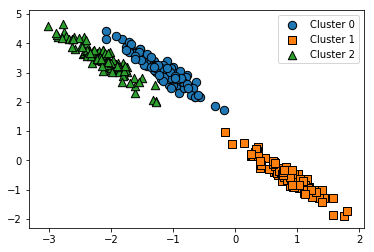

In [12]:
#원래 make_bolbs로 생성되는 데이터는 군집이 원형으로 분산이 되므로
#타원의 형태로 분산이 되게 변환을 시켜준다. 
#타원 형태의 데이터생성, 시각화 

from sklearn.datasets import make_blobs
X,y = make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=0.5, random_state=0)
#타원의 형태를 위해 곱해주는 값 생성, 곱해줌
transformation=[[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation) #타원 형태의 데이터 

clusterDF = pd.DataFrame(data=X_aniso, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y
 
visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

In [13]:
#3개의 군집기반 데이터를 kmeans적용
kmeans = KMeans(3, random_state=0)
kmeans_label = kmeans.fit_predict(X_aniso)
clusterDF['kmeans_label'] = kmeans_label

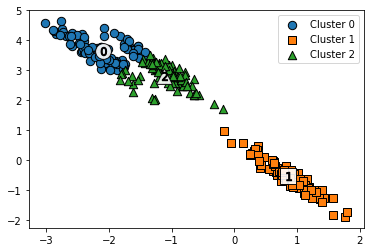

In [14]:
visualize_cluster_plot(kmeans, clusterDF, 'kmeans_label',iscenter=True)

In [18]:
#GMM적용
gmm=GaussianMixture(n_components=3, random_state=0)
gmm_label=gmm.fit(X_aniso).predict(X_aniso)
clusterDF['gmm_label']=gmm_label

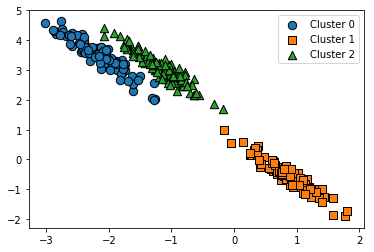

In [19]:
visualize_cluster_plot(gmm, clusterDF, 'gmm_label',iscenter=False)

In [21]:
#매핑결과 비교, kmeans와 GMM의 군집 효율성 비교
print('### KMeans Clustering ###')
print(clusterDF.groupby('target')['kmeans_label'].value_counts())
print('\n### Gaussian Mixture Clustering ###')
print(clusterDF.groupby('target')['gmm_label'].value_counts())

### KMeans Clustering ###
target  kmeans_label
0       2                73
        0                27
1       1               100
2       0                86
        2                14
Name: kmeans_label, dtype: int64

### Gaussian Mixture Clustering ###
target  gmm_label
0       2            100
1       1            100
2       0            100
Name: gmm_label, dtype: int64


GMM의 경우는 kmeans보다 더 유연하게 데이터셋 적용이 가능하다, 하지만 군집화를 하는데 시간이 오래걸린다 

### 7.5. DBSCAN
- 밀도기반의 가장 대표적인 알고리즘(앞에서의 kmeans의 경우는 거리기반, GMM은 확률기반)
- 기하학적으로 복잡한 데이터셋에도 효과적인 적용이 가능하다. 
- **입실론 주변영역**과 **최소데이터개수**를 가진다. 
- DBSCAN은 입실로노 주변 영역의 최소 데이터 개수를 포함하는 밀도 기준을 충족하는 데이터인 핵심 포인트를 연결하면서 군집화를 진행한다. 
- 군집화 과정은 437p 참고하기

In [22]:
#DBCSAN을 붓꽃 데이터에 적용하기 
#붓꽃 데이터 생성
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length','sepal_width','petal_length','petal_width']

irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target

In [25]:
#DBSCAN적용 
from sklearn.cluster import DBSCAN
dbscan=DBSCAN(eps=0.6, min_samples=8, metric='euclidean')
dbscan_labels=dbscan.fit_predict(iris.data)

#군집화 결과 데이터 프레임에 저장
irisDF['dbscan_cluster']=dbscan_labels
irisDF['target']= iris.target

In [26]:
#매핑결과 확인
iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

target  dbscan_cluster
0        0                49
        -1                 1
1        1                46
        -1                 4
2        1                42
        -1                 8
Name: dbscan_cluster, dtype: int64


-1 cluster는 노이즈에 속하는 것을 의미한다. DBSCAN의 경우는 군집의 개수를 정하는 것이 비효율 적일 수가 있다. 최적화된 군집의 수를 정해주기 때문이다, 따라서 적절한 모수의 eps와 min_samples를 정해주는 것이 더 중요하다. 

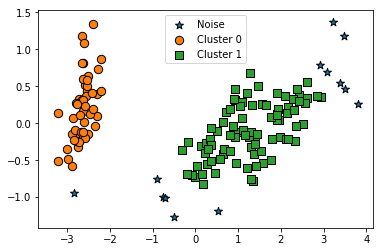

In [28]:
#2차원 시각화를 위한 PCA확인 
from sklearn.decomposition import PCA
# 2차원으로 시각화하기 위해 PCA n_componets=2로 피처 데이터 세트 변환
pca = PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(iris.data)
# visualize_cluster_2d( ) 함수는 ftr1, ftr2 컬럼을 좌표에 표현하므로 PCA 변환값을 해당 컬럼으로 생성
irisDF['ftr1'] = pca_transformed[:,0]
irisDF['ftr2'] = pca_transformed[:,1]

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

- eps를 늘리면 노이즈가 작아진다. 
- min_samples를 크게하면 노이즈 데이터의 수가 늘어난다. 

target  dbscan_cluster
0        0                50
1        1                50
2        1                47
        -1                 3
Name: dbscan_cluster, dtype: int64


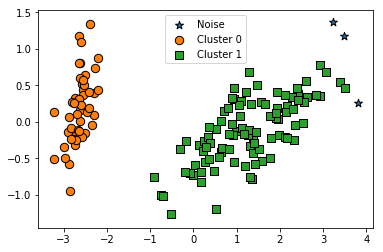

In [29]:
#eps를 늘리는 경우 확인 eps=0.8
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.8, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

target  dbscan_cluster
0        0                48
        -1                 2
1        1                44
        -1                 6
2        1                36
        -1                14
Name: dbscan_cluster, dtype: int64


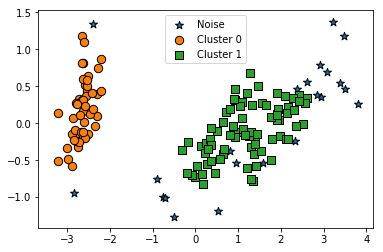

In [31]:
#min_sample을 늘리는 경우
dbscan = DBSCAN(eps=0.6, min_samples=16, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)
visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

make_circle()로 원형 데이터 생성하고, kmeans, GMM, DBSCAN을 모두 적용하여 효율성 확인한다. 

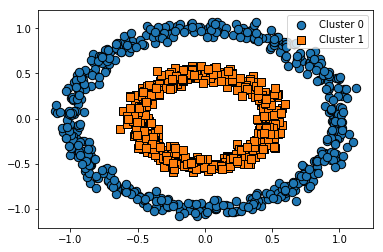

In [32]:
#원형으로 이루어진 데이터를 생성한다. 
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, shuffle=True, noise=0.05, random_state=0, factor=0.5)
clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

#데이터 확인 
visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

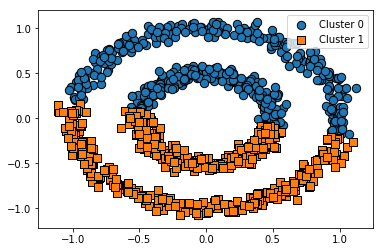

In [37]:
#kmeans적용
from sklearn.cluster import KMeans

kmeans=KMeans(n_clusters=2, max_iter=1000, random_state=0)
kmeans_labels= kmeans.fit_predict(X)
clusterDF['kmeans_cluster']= kmeans_labels
visualize_cluster_plot(kmeans, clusterDF, 'kmeans_cluster', iscenter=False)

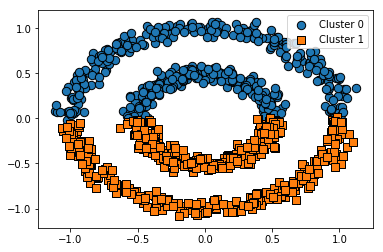

In [42]:
#GMM적용하는 경우 
from sklearn.mixture import GaussianMixture

gmm=GaussianMixture(n_components=2, random_state=0)
gmm_label=gmm.fit(X).predict(X)
clusterDF['gmm_cluster']= gmm_label

#시각화 확인
visualize_cluster_plot(gmm, clusterDF, 'gmm_cluster', iscenter=False)

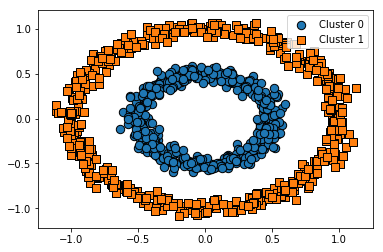

In [41]:
#DSCAM적용하는 경우 
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=10, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X)
clusterDF['dbscan_cluster'] = dbscan_labels

visualize_cluster_plot(dbscan, clusterDF, 'dbscan_cluster', iscenter=False)

DBSCAN 군집화로 원하는 방향으로 정확히 군집화가 완료되었다. 

### 7.6. 군집화실습-고객 세그먼테이션
- 얼마나 많은 매출을 발생시키냐에 따라 고객 기준을 정하는 중요한 요소이다. -> 타깃마케팅이 목표
- RFM기법을 이용한다. 

In [43]:
#데이터 로드 
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

retail_df=pd.read_excel(io='Online Retail.xlsx')
retail_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


- null데이터의 제거 : 고객 식별변호가 없으면 어차피 RFM못하므로 삭제
- 오류 데이터 삭제: quntity, unitprice가 0보다 작은 경우 삭제

In [45]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      397884 non-null object
StockCode      397884 non-null object
Description    397884 non-null object
Quantity       397884 non-null int64
InvoiceDate    397884 non-null datetime64[ns]
UnitPrice      397884 non-null float64
CustomerID     397884 non-null float64
Country        397884 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


In [46]:
#오류 데이터의 삭제 
retail_df= retail_df[retail_df['Quantity']>0]
retail_df=retail_df[retail_df['UnitPrice']>0]

#null데이터의 제거
retail_df=retail_df[retail_df['CustomerID'].notnull()]

print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [47]:
#주요 고객의 나라 확인 
retail_df['Country'].value_counts()[:5]
#영국외의 다른 나라는 고려하지 않는다. (drop)

United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Name: Country, dtype: int64

In [48]:
retail_df = retail_df[retail_df['Country']=='United Kingdom']
print(retail_df.shape)

(354321, 8)


#### RFM기반 데이터 가공
- Unitprice와  Quantity를 곱해 주문금액 데이터를 생성한다
- customerNO도 더 편리한 식별성을 위해 float에서 int형 변경

In [49]:
#데이터 변환
retail_df['sale_amount'] = retail_df['Quantity'] * retail_df['UnitPrice']
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

In [51]:
#해당 온라인 판매금액과 고객이름을 같이 출력
print(retail_df['CustomerID'].value_counts().head(5))
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64
CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


In [52]:
#유일한 식별자의 생성
retail_df.groupby(['InvoiceNo','StockCode'])['InvoiceNo'].count().mean()

1.028702077315023

In [57]:
# DataFrame의 groupby() 의 multiple 연산을 위해 agg() 이용
# Recency는 InvoiceDate 컬럼의 max() 에서 데이터 가공
# Frequency는 InvoiceNo 컬럼의 count() , Monetary value는 sale_amount 컬럼의 sum()
aggregations = {
    'InvoiceDate': 'max', #가장최근일자
    'InvoiceNo': 'count',#횟수 
    'sale_amount':'sum' #총금액
}
cust_df = retail_df.groupby('CustomerID').agg(aggregations)
# groupby된 결과 컬럼값을 Recency, Frequency, Monetary로 변경
cust_df = cust_df.rename(columns = {'InvoiceDate':'Recency',
                                    'InvoiceNo':'Frequency',
                                    'sale_amount':'Monetary'
                                   }
                        )
cust_df = cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


In [58]:
import datetime as dt

cust_df['Recency'] = dt.datetime(2011,12,10) - cust_df['Recency'] #뺀일자
cust_df['Recency'] = cust_df['Recency'].apply(lambda x: x.days+1) #+1
print('cust_df 로우와 컬럼 건수는 ',cust_df.shape)
cust_df.head(3)
#R,F,M모두 생성 완료

cust_df 로우와 컬럼 건수는  (3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73


### RFM기반 고객 세그먼테이션
- 앞에서 확인했듯이 소매업체의 대규모 주문을 포함하고 있으므로 R,F,M의 값을 시각적으로 확인했을 때 왜곡된 결과가 나온다. 

(array([3.887e+03, 1.900e+01, 9.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([3.75000000e+00, 2.59691050e+04, 5.19344600e+04, 7.78998150e+04,
        1.03865170e+05, 1.29830525e+05, 1.55795880e+05, 1.81761235e+05,
        2.07726590e+05, 2.33691945e+05, 2.59657300e+05]),
 <a list of 10 Patch objects>)

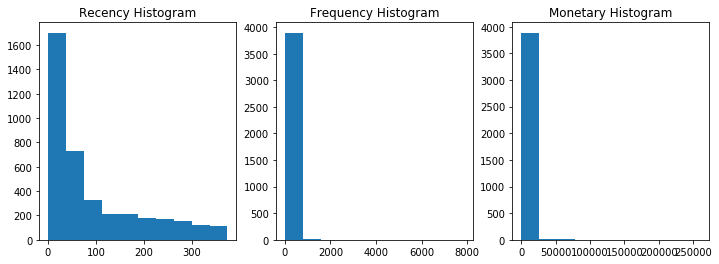

In [62]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])

In [64]:
#왜곡된 데이터임을 확인
cust_df[['Recency','Frequency','Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


왜곡된 정도가 높은 데이터임을 확인했다. 이런 경우에는 kmeans를 적용해도 변별력이 높은 결과가 나오지 않는다. 이에 대해 standardscaler를 적용한다. 

In [65]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = cust_df[['Recency','Frequency','Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))

실루엣 스코어는 : 0.592


In [66]:
#여러 클러스터링 수를 리스트로 받아, 각각의 실루엣계수를 출력하는 경우 
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [67]:
#각 클러스터링 수를 바아 클러스터링 시각화 
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

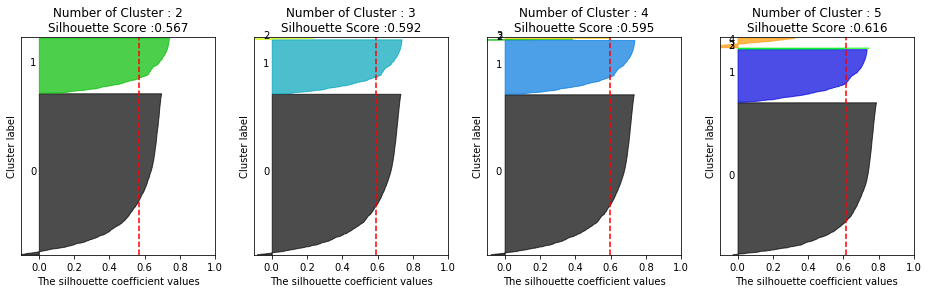

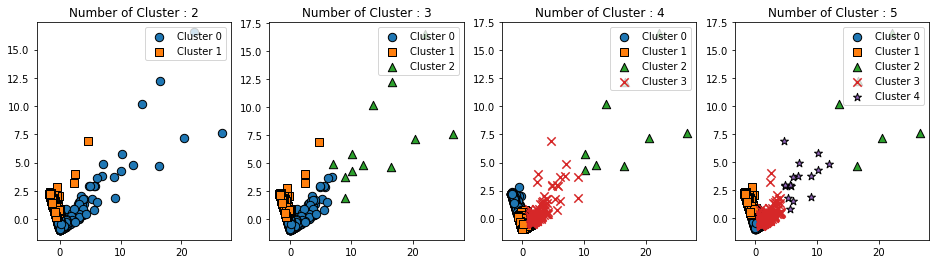

In [68]:
#standard scale한 결과에 대한 kmeans결과 시각화 
visualize_silhouette([2,3,4,5], X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5], X_features_scaled)

- k=2의 경우, 너무 개괄적인 군집분석이 됨. 따라서 k의 수를 늘리면 더 성능이 좋아질 것으로 예측하나 매우 작은 데이터 수의 군집이 새로 생성되어 원하는 형태가 되지 않는다. 
- 이에 따라 log변화을 해준다. 

In [72]:
#log변환하는 과정
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

In [73]:
#로그변환 이후에 standardscaler을 적용한다. 
X_features = cust_df[['Recency_log','Frequency_log','Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 :{0:.3f}'.format(silhouette_score(X_features_scaled,labels)))

실루엣 스코어는 :0.303


In [78]:
X_features = cust_df[['Recency_log','Frequency_log','Monetary_log']].values
X_features #형태 확인 

array([[ 5.78996017,  0.69314718, 11.25395523],
       [ 1.38629436,  4.6443909 ,  8.34212765],
       [ 0.69314718,  8.43294164, 10.42586806],
       ...,
       [ 2.19722458,  2.56494936,  5.1876651 ],
       [ 1.60943791,  6.62936325,  7.64772879],
       [ 3.78418963,  4.26267988,  7.51658563]])

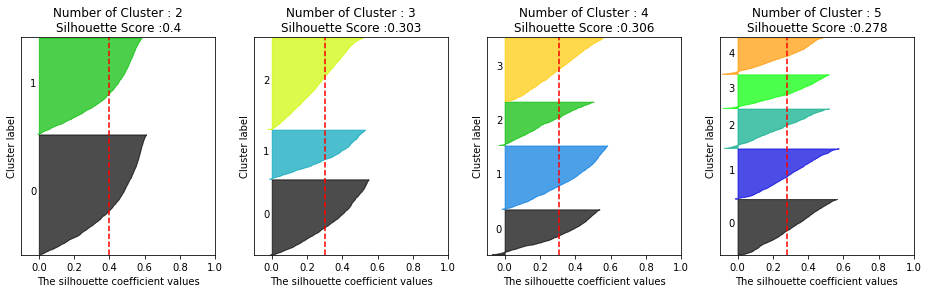

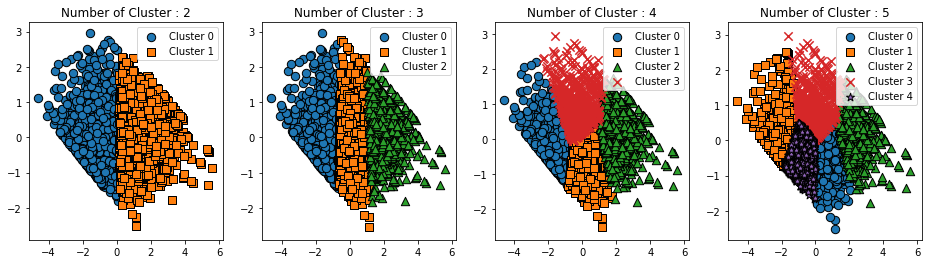

In [74]:
#시각화 
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)